# Dropsonde Based Surface Evaporation per flight

This routine calculates the surface evaporation from the dropsondes over sea surface. The formula relies on Howland et al. (1983,https://doi.org/10.1175/1520-0493(1983)111<2255:TMBOTN>2.0.CO;2 )

E=C_d*rho_a*(q_s-q_a)*v --> (actually this formula comes from Rao et al. (1981))

C_d   : drag coefficient( 1.4e-3 for v< 13 m/s, 1.6e-3 for v>13m/s)
rho_a : air density at sea level
q_s   : saturation specific humidity
q_a   : actual specific humidity

## Configuration

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Predefinitions

In [2]:
campaign="HALO_AC3"
ar_of_day="AR_entire_2"
calibrated_hamp=True
flight=["RF06"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"

scalar_based_div=False
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


## Prepare Dropsonde Data

In [3]:
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))

In [21]:
#[*Dropsondes.keys()]
temp_sonde=Dropsondes["tdry"].copy()
temp_sonde
for sonde in [*temp_sonde.keys()]:
    #print(temp_sonde[sonde]["gpsalt"].values[0:10])
    surface_data=temp_sonde[sonde].isel({"time":slice(0,10)})
    max_alt=float(surface_data["gpsalt"].max())
    print(max_alt) 
    

16.68000030517578
21.979999542236328
4.239999771118164
23.690000534057617
29.350000381469727
19.670000076293945
3.450000047683716
19.59000015258789
12.489999771118164
20.469999313354492
25.40999984741211
24.350000381469727
30.25
16.530000686645508
17.670000076293945
-16.110000610351562
8.260000228881836
15.930000305175781
10.869999885559082
8.199999809265137
7.190000057220459
10.029999732971191
14.369999885559082


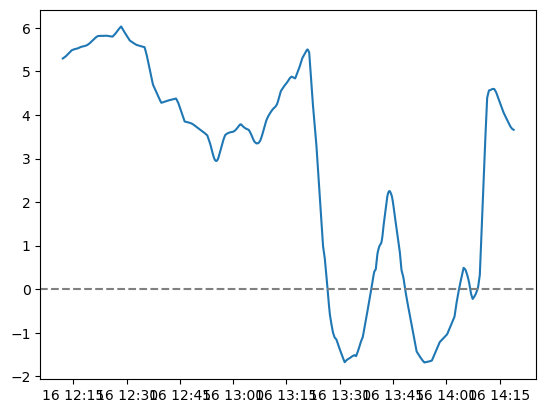

In [11]:
#halo_era5
import matplotlib.pyplot as plt
sst=halo_era5["Interp_SST"]

plt.plot(sst-273.15)
plt.axhline(y=0,ls="--",color="grey")